In [1]:
peptide_filepath = "data/LSTM_ecoli_true.csv"

In [2]:
import scipy
import numpy as np
import pandas as pd
from collections import defaultdict as dd
from matplotlib import pyplot as plt

In [3]:
# Load data
dat = pd.read_csv(peptide_filepath, index_col=0)

In [4]:
# CV columns start with "X" due to some limitation in R; remove that and convert to ints
x = [int(i[1:]) for i in dat.columns if i.startswith("X")]

In [5]:
# Split peptides according to their CVmax; put full signal in dict
cvmax = dd(list)
for i in range(dat.shape[0]):
     pmax = x[np.argmax(dat.iloc[i,:])]
     cvmax[pmax].append(dat.iloc[i,:].values)

In [6]:
def compute_meanvar_from_dist(value, freq) -> (float, float):
    """
    Computes the mean and variance of a population distribution (histogram).
    """
    m = np.sum(value*freq) / np.sum(freq)
    var = np.sum(freq * (value-m)**2) / np.sum(freq)
    return m, var

In [7]:
dist_list2 = dd(list)
pvals2 = dd(list)
num_repetitions = 100
num_samples = 1000
for i in x:
     print(f"cv: {i}")
     for sig in cvmax[i]:
         m, v = compute_meanvar_from_dist(x, sig)
#        g = scipy.stats.norm.pdf(x, i, np.sqrt(np.mean(all_vars)))  # more generous assumption: all distributions are the same and sufficiently summarized by CVmax
         g = scipy.stats.norm.pdf(x, m, np.sqrt(v))  # less generous assumption: distribution can be summarized by its mean and variance
         dist = scipy.stats.wasserstein_distance(sig/np.sum(sig), g/np.sum(g))
         p_count = 0
         if np.sum(g) == 0:
             continue
         for j in range(num_repetitions):
             ref = np.random.choice(x, size=num_samples, p=g/np.sum(g))
             ref_distr = np.histogram(ref, bins=x + [x[-1]*2-x[-2]])[0]
             ref_distance = scipy.stats.wasserstein_distance(ref_distr/np.sum(ref_distr), g/np.sum(g))
             if dist > ref_distance:
                 p_count += 1
         pvals2[i].append(p_count/(j+1))
         dist_list2[i].append(dist)

cv: 20
cv: 25
cv: 30
cv: 35
cv: 40
cv: 45
cv: 50
cv: 55
cv: 60
cv: 65
cv: 70
cv: 75
cv: 80
cv: 85
cv: 90
cv: 95


/tmp/ipykernel_30701/428038384.py:2: RuntimeWarning: invalid value encountered in scalar divide
  plt.bar(i, np.sum(np.array(pvals2[i])>0.95) / len(pvals2[i]), color="#3b528b", width=5, edgecolor="black")


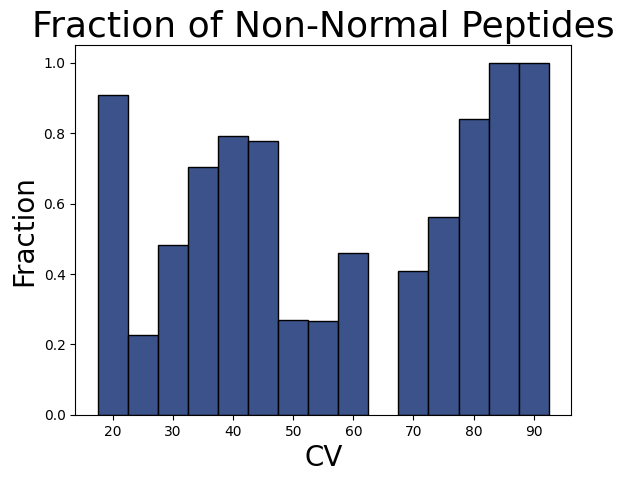

In [8]:
for i in x:
    plt.bar(i, np.sum(np.array(pvals2[i])>0.95) / len(pvals2[i]), color="#3b528b", width=5, edgecolor="black")
plt.xlabel("CV", fontsize=20)
plt.ylabel("Fraction", fontsize=20)
plt.title("Fraction of Non-Normal Peptides", fontsize=26)
plt.savefig("fraction_nonnormal2.png")
plt.savefig("fraction_nonnormal2.svg")

In [9]:
x

[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [11]:
pvals.keys()

NameError: name 'pvals' is not defined

20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


/tmp/ipykernel_30701/3363618916.py:4: RuntimeWarning: invalid value encountered in scalar divide
  plt.bar(i, np.sum(np.array(pvals2[i])>0.95) / len(pvals2[i]), color="#3b528b", width=5, edgecolor="black")


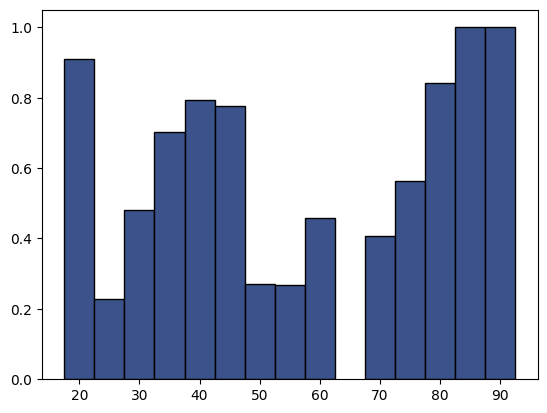

In [10]:
plt.figure()
for i in x:
    print(i)
    plt.bar(i, np.sum(np.array(pvals2[i])>0.95) / len(pvals2[i]), color="#3b528b", width=5, edgecolor="black")